<a href="https://colab.research.google.com/github/r-doz/PML2025/blob/main/./Homeworks/Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2

Probabilistic Machine Learning -- Spring 2025, UniTS

### Problem 1: Marginal Likelihood Optimisation

Given the Bayesian Linear Regression model implemented in the Notebook 6, considering the same dataset and variables (Apparent Temperature vs Humidity), optimize alpha and beta by maximizing the Marginal Likelihood.

Note: You can show here only the piece of code that you used and write the optimal alpha and beta that you obtained (so you can run it in directly on Notebook 6)

Hint: import scipy.optimize as optimize

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

In [9]:
weatherHistory = pd.read_csv('https://raw.githubusercontent.com/DavideScassola/PML2024/main/Notebooks/data/weatherHistory.csv')
weatherHistory.info()

#Let's reduce the size of the dataset by considering one row for each day (corresponding to 16:00), only in 2015
#Training: April, Test: May
weatherHistory['Formatted Date'] = pd.to_datetime(weatherHistory['Formatted Date'], utc=True)
data = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 4))].reset_index(drop=True)
data.info()
data_test = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 5))].reset_index(drop=True)


def linear_basis(x):
    return x

#in this case x and y are row vectors, so we need to convert them to column vectors
x = data["Humidity"].to_numpy().reshape(-1,1)
y = data["Apparent Temperature (C)"].to_numpy().reshape(-1,1)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29

In [10]:
def compute_marginal_log_likelihood(log_params, x, y, basis_function):
    # to garantee that the parameters are positive, we use the log of the parameters
    log_alpha, log_beta = log_params
    alpha = np.exp(log_alpha)
    beta = np.exp(log_beta)
    
    # Size of the dataset
    N = len(y)
    # Number of parameters
    M = basis_function(x).shape[1]
    # Design matrix
    PHI = np.hstack((np.ones((N, 1)), basis_function(x)))
    
    # Inverse covariance matrix of posterior
    A = alpha * np.eye(PHI.shape[1])
    S_N_inv = A + beta * PHI.T @ PHI

    try:
        sign, logdetS_N_inv = np.linalg.slogdet(S_N_inv)
        if sign != 1:
            return np.inf
        S_N = np.linalg.inv(S_N_inv)
    except np.linalg.LinAlgError:
        return np.inf

    # Posterior mean
    mN = beta * S_N @ PHI.T @ y
    y_fit = PHI @ mN

    # log marginal likelihood
    log_likelihood = -0.5 * N * np.log(2 * np.pi) - 0.5 * logdetS_N_inv \
                     - 0.5 * beta * np.sum((y - y_fit)**2) - 0.5 * alpha * mN.T @  mN \
                     + 0.5 * M * log_alpha + 0.5 * N * log_beta

    return -log_likelihood  # minimize => maximize marginal likelihood


In [11]:
res = minimize(
    compute_marginal_log_likelihood,
    x0=np.log([1e-3, 1.0]),  # initial guess in log space
    args=(x, y, linear_basis),
    method='L-BFGS-B',
    #bounds=[(-10, 10), (-10, 10)]  # log(alpha), log(beta) bounds
)

# Extract the optimal parameters
opt_alpha, opt_beta = np.exp(res.x)
print(f"Optimal alpha: {opt_alpha}")
print(f"Optimal beta: {opt_beta}")



Optimal alpha: 0.0020252360018120125
Optimal beta: 0.08079850924412836


### Problem 2: Rejection Sampling

Consider the unnormalized probability density function:

$$
\tilde{p}(x) = \exp\left(-\frac{x^4}{4} - \frac{x^2}{2}\right)
$$

This density is defined for $x \in \mathbb{R}$, but it is not normalized. Let $Z$ be its normalization constant:

$$
Z = \int_{-\infty}^{\infty} \tilde{p}(x)\, dx
$$

You are given access to a proposal distribution $q(x) = \mathcal{N}(0, 1)$ from which you can sample and evaluate its density.

-  Implement and then use rejection sampling with $q(x)$ to generate samples from the normalized target distribution $p(x) = \frac{1}{Z} \tilde{p}(x)$.
    
- Estimate the normalization constant $Z$ (hint: see your course notes!)

- Compare your result with a numerical approximation of $Z$ using integration methods (e.g., scipy.integrate.quad).


In [12]:
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [86]:
def rejection_sampling(target_pdf, proposal_pdf, proposal_sampler, n_samples):
    
    samples = []
    # Calculate the maximum ratio of target_pdf to proposal_pdf
    max_ratio = max(target_pdf(x) / proposal_pdf(x) for x in np.arange(-10, 10, 0.01)) 
    i =0 
    
    while len(samples) < n_samples:
        # Sample from proposal distribution
        x = proposal_sampler() 
        #print(f"x numero: {i+1}")
        i = i + 1
        u = np.random.uniform(0, max_ratio * proposal_pdf(x))
        
        if u <= target_pdf(x):
            #print('entrato')
            samples.append(x)
        else:
            continue
            # print('non entrato')

    P_accepted = 1 - (i - len(samples)) / i
    print(f"Probability of being accepted: {P_accepted}")
    print(f"partition function: {P_accepted * max_ratio}")


    return samples

Probability of being accepted: 0.774593338497289
partition function: 1.9416175636181257
Valore dell'integrale Z: 1.9352478184967319
Errore stimato: 9.261123738949812e-11


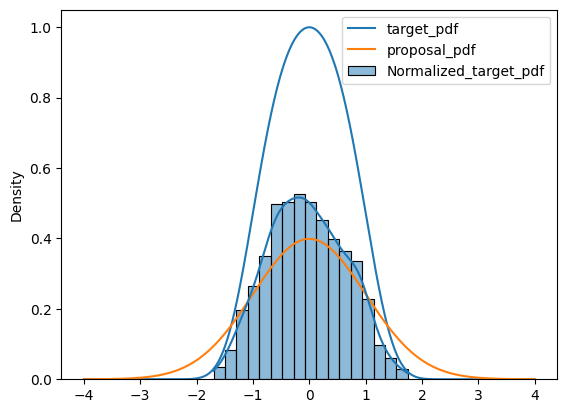

In [88]:
def target_pdf(x):
    return np.exp((-x**4/4) - (x**2/2))    # Example target distribution
def proposal_pdf(x):
    return norm.pdf(x, loc=0, scale=1)    # Example proposal distribution

samples = rejection_sampling(target_pdf, proposal_pdf,  np.random.normal, n_samples=1000)

# numerical approximation of Z using integration methods (scipy.integrate.quad).
Z, error = quad(target_pdf, -np.inf, np.inf)

print("Valore dell'integrale Z:", Z)
print("Errore stimato:", error)

x = np.linspace(-4, 4, 1000)
plt.plot(x, target_pdf(x), label="target_pdf")
plt.plot(x, proposal_pdf(x), label="proposal_pdf")
_ = sns.histplot(samples, kde=True, stat='density', label='Normalized_target_pdf')
_ = plt.legend()

### Problem 3: MCMC Convergence Diagnostics

You have implemented a Metropolis-Hastings algorithm and used it to draw samples from a univariate target distribution. In this exercise, you will compute convergence diagnostics from scratch to assess whether your chains have mixed well.

Consider 4 parallel chains, each of length $N$ (after burn-in), starting from different initial values (use
initial_values = [-10, -2, 2, 10]). The unnormalized probability density function $\tilde{p}(x)$ is defined as a mixture of two Gaussian distributions:

$$
\tilde{p}(x) = \mathcal{N}(x; -5, 1) + \mathcal{N}(x; 5, 1)
$$

Perform the following steps two times, considering a proposal standard deviation of 0.1 and 2.0:

- Compute the within variance $W$ and the between variance $B$
- Compute the statistics $\hat{R}$
- For a single chain of samples $x_1, x_2, \dots, x_N$, compute the lag-$k$ autocorrelation $\rho_k$ and plot $\rho_k$ for $k = 1, 2, \dots, 20$
- Estimate the effective number of samples $n_{eff}$

Repeat the analysis with the distribution:

$$
\tilde{p}(x) = \mathcal{N}(x; -2, 1) + \mathcal{N}(x; 2, 1)
$$

Discuss the results



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
import torch
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics import tsaplots


In [ ]:
def sample_from_q(x, sigma):
    return np.random.normal(x, sigma)

def q_y_given_x(y, x, sigma):
    return stats.norm(x, sigma).pdf(y)

def metropolis_hastings_multi_chain(x_0_list, n, sigma, p_tilde):
    num_chains = len(x_0_list)
    chains = np.zeros((num_chains, n))
    rejections = [0] * num_chains

    for c in range(num_chains):
        x = np.zeros(n)
        x[0] = x_0_list[c]
        print(f"\n### Catena {c+1} - Inizio da x[0] = {x[0]} - Varianza = {sigma} ###")

        for i in range(1, n):
            current_x = x[i-1]
            y = sample_from_q(current_x, sigma)

            alpha = min(1., p_tilde(y)/ p_tilde(current_x) * q_y_given_x(current_x, y, sigma) / q_y_given_x(y, current_x, sigma))

            if np.random.rand() < alpha:
                x[i] = y
            else:
                x[i] = current_x
                rejections[c] += 1

        chains[c] = x

    return chains, rejections

# function to compute within variance, between variance, R
def W_B_R(chains): 
    
    n = chains.shape[1]  # number of samples in each chain
    burn_in = int(n/2)
    chains = chains[:, burn_in:]

    means = []
    S = []

    for i in range(len(chains)):
        means = np.append(means, np.mean(chains[i,:]))
        s = sum((chains[i,:] - means[-1]) ** 2) / (n - 1)
        S = np.append(S, s)

    means_of_means = np.mean(means)
    
    within_variance = sum(S)/chains.shape[0]
    between_variance = sum((means - means_of_means) ** 2) * (n / (chains.shape[0] - 1))
    upper_bound = ((n - 1) / chains.shape[0]) * within_variance + (1 / n) * between_variance
    R = np.sqrt(upper_bound / within_variance)
        
    return within_variance, between_variance, upper_bound, R

# Function to compute Variogram at lag K
def compute_V_k(chains, k):
    M, N = chains.shape  # M chain, N elements of chains
    V_k = 0
    diffs = []
    
    for m in range(M):
        diffs = chains[m, k:] - chains[m, :-k]  # shape (N - k,)
        V_k += np.sum(diffs ** 2)
    return V_k / (M * (N - k))  # V_k = 1/(M*(N-k)) * sum_{m=1}^M sum_{i=1}^{N-k} (x_m(i+k) - x_m(i))^2

def compute_autocorrelations(chains, upper_bound, max_lag=None):
    # M, N = chains.shape
    ro_list = []
    k = 1
    while True:
        if max_lag and k + 2 >= max_lag:
            break  # Limite superiore di sicurezza
        V_k = compute_V_k(chains, k)
        ro_k = 1 - (V_k / (2 * upper_bound))  
        ro_list.append(ro_k)

        V_k1 = compute_V_k(chains, k + 1)
        ro_k1 = 1 - (V_k1 / (2 * upper_bound))
        ro_list.append(ro_k1)

        V_k2 = compute_V_k(chains, k + 2)
        ro_k2 = 1 - (V_k2 / (2 * upper_bound))
        ro_list.append(ro_k2)

        if ro_k1 + ro_k2 < 0:
            break

        k += 3  

    return k, ro_list

# Function to compute the effective sample size
def num_eff(m,n,ro):
    num_eff = m * n / (1 + 2 * np.sum(ro))
    return num_eff

In [74]:
def p_tilde_1(x):
    return stats.norm(-5, 1).pdf(x) + stats.norm(5, 1).pdf(x) 

def p_tilde_2(x):
    return stats.norm(-2, 1).pdf(x) + stats.norm(2, 1).pdf(x) 

x_0_list = [-10, -2, 2, 10]  # initial values for the chains

n_steps = 1000  

sigma_1 = 0.1
sigma_2 = 2.0

## P_tilde 1

In [ ]:
# Run the Metropolis-Hastings algorithm with different variances with p_tilde_1
chains_1, rejections_1 = metropolis_hastings_multi_chain(x_0_list, n_steps, sigma_1, p_tilde_1)
print(f"Rejections for Variance 0.1: {rejections_1}")
chains_2, rejections_2 = metropolis_hastings_multi_chain(x_0_list, n_steps, sigma_2, p_tilde_1)
print(f"Rejections for Variance 2.0: {rejections_2}")

# Evaluate within variance, between variance, R for both grops of chains 
within_variance_1, between_variance_1, upper_bound_1, R_1= W_B_R(chains_1)
print(f"Within variance for sigma_1: {within_variance_1} \nBetween variance for sigma_1: {between_variance_1} \nUpper bound for sigma_1: {upper_bound_1} \nR for sigma_1: {R_1}")
within_variance_2, between_variance_2, upper_bound_2, R_2= W_B_R(chains_2)
print(f"Within variance for sigma_2: {within_variance_2} \nBetween variance for sigma_2: {between_variance_2} \nUpper bound for sigma_2: {upper_bound_2} \nR for sigma_2: {R_2}")

'''
COMMENT:
The R values indicate that for both values of sigma, the chains are not converging.
'''


### Catena 1 - Inizio da x[0] = -10.0 - Varianza = 0.1 ###

### Catena 2 - Inizio da x[0] = -2.0 - Varianza = 0.1 ###

### Catena 3 - Inizio da x[0] = 2.0 - Varianza = 0.1 ###

### Catena 4 - Inizio da x[0] = 10.0 - Varianza = 0.1 ###
Rejections for Variance 0.1: [57, 33, 40, 42]

### Catena 1 - Inizio da x[0] = -10.0 - Varianza = 2.0 ###

### Catena 2 - Inizio da x[0] = -2.0 - Varianza = 2.0 ###

### Catena 3 - Inizio da x[0] = 2.0 - Varianza = 2.0 ###

### Catena 4 - Inizio da x[0] = 10.0 - Varianza = 2.0 ###
Rejections for Variance 2.0: [509, 495, 478, 491]
Within variance for sigma_1: 0.3020735241448408 
Between variance for sigma_1: 32363.944038675974 
Upper bound for sigma_1: 107.80680669384995 
R for sigma_1: 18.891513802605985
Within variance for sigma_2: 3.618641760379674 
Between variance for sigma_2: 13973.81362146514 
Upper bound for sigma_2: 917.7295932762888 
R for sigma_2: 15.925188174856219


In [77]:
# List of ro_k (Varianza 0.1) 
k_1,ro_1 = compute_autocorrelations(chains_1, upper_bound_1, max_lag= 800)
# List of ro_k (Varianza 2.0)
k_2,ro_2 = compute_autocorrelations(chains_2, upper_bound_2, max_lag=800)

# effective number of samples 
n_eff_1 = num_eff(chains_1.shape[0], chains_1.shape[1], ro_1)
n_eff_2 = num_eff(chains_2.shape[0], chains_2.shape[1], ro_2)

print(f'k_1: {k_1} --->  ro list for chains_1 (sigma=0.1): {ro_1}')
print(f'k_2: {k_2} --->  ro list for chains_2 (sigma=2.0): {ro_2}')
print(f"Effettive samples for chains_1 (sigma=0.1): {n_eff_1}")
print(f"Effettive samples for chains_2 (sigma=2.0): {n_eff_2}")


k_1: 799 --->  ro list for chains_1 (sigma=0.1): [0.9999567215623891, 0.9999097089034618, 0.9998610767402663, 0.9998126649024603, 0.9997646939826585, 0.9997168929659977, 0.9996712024281671, 0.9996254280899864, 0.9995794324116808, 0.9995342252981684, 0.9994894681688159, 0.9994453165786171, 0.9993994719518345, 0.9993517092770354, 0.9993047930968466, 0.9992570948382318, 0.9992101273282791, 0.9991631448444734, 0.9991138705583805, 0.9990633291715992, 0.9990110328896538, 0.9989571183842639, 0.9989038332000365, 0.9988508896234731, 0.9987979585538969, 0.9987439191020241, 0.99868895157199, 0.9986323695046899, 0.9985782365268108, 0.9985245390960852, 0.9984723315119992, 0.9984193508754541, 0.9983694259375868, 0.9983196599640639, 0.9982681677204049, 0.998215019257112, 0.9981603951327275, 0.9981063648449889, 0.998051896263118, 0.9979991246463304, 0.9979487906698787, 0.9978999850097986, 0.997849427471761, 0.9977973064175689, 0.9977453308737801, 0.9976929293040414, 0.9976397017373911, 0.9975874132629

In [78]:
def plot_chains(chains, t, p_tilde, title, x0_values):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8)) 
    plt.suptitle(title, fontsize=16) 

    for i, ax in enumerate(axs.flat):
        ax.plot(t, p_tilde(t), label='p(x)')
        ax.hist(chains[i, :], bins=50, density=True, alpha=0.7, label='samples')
        ax.set_title(f'Inizializzazione a x0 = {x0_values[i]}')
        ax.set_xlim(-10, 10)
        ax.set_ylim(0, 1)
        ax.legend()

    plt.tight_layout()
    plt.show()

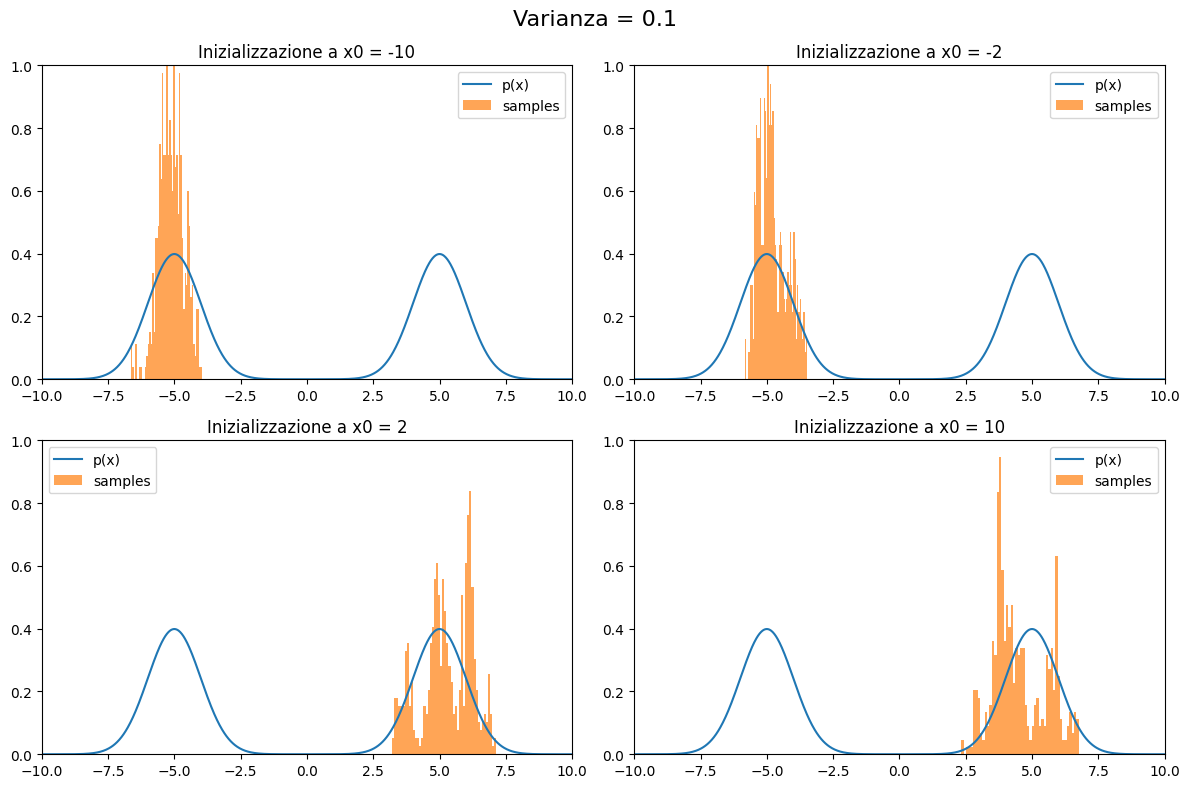

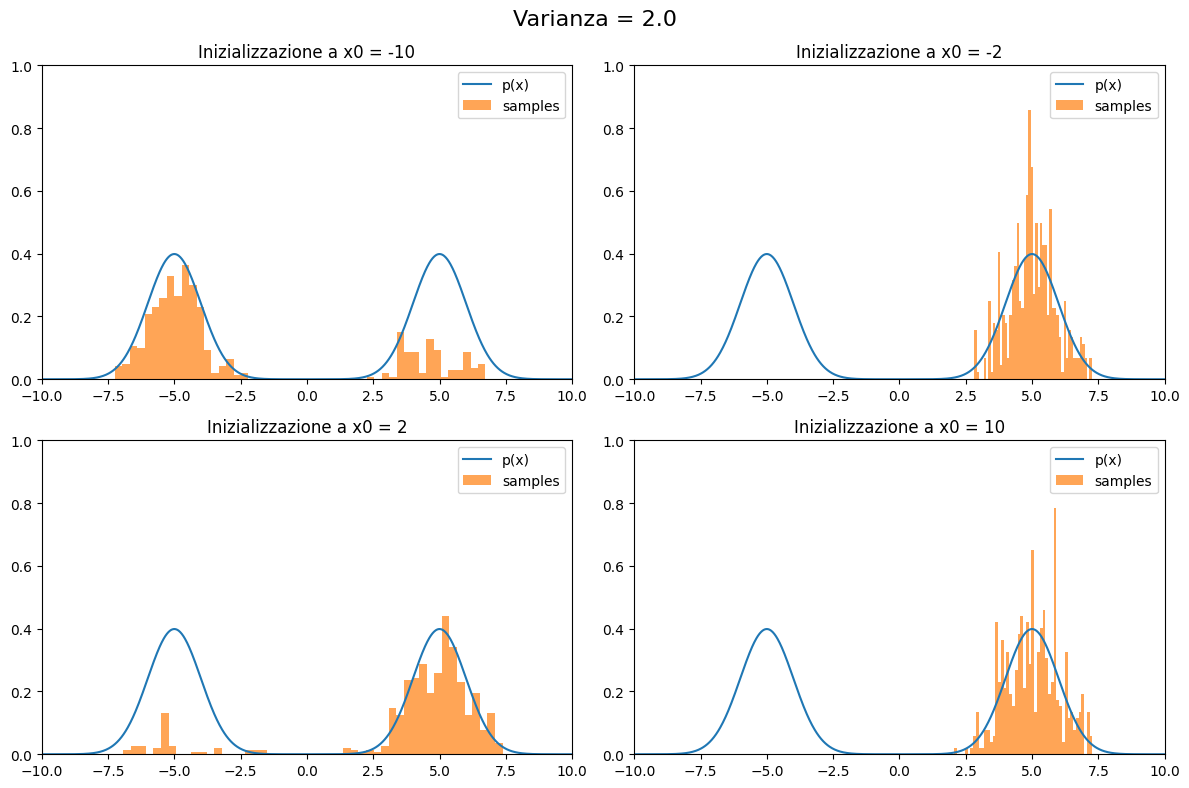

In [ ]:
burn_in = int(n_steps/2)
chains_1_burned = chains_1[:, burn_in:]
chains_2_burned = chains_2[:, burn_in:]
t = np.linspace(-10, 10, 1000)

plot_chains(chains_1_burned, t, p_tilde_1, title="Varianza = 0.1", x0_values=x_0_list)
plot_chains(chains_2_burned, t, p_tilde_1, title="Varianza = 2.0", x0_values=x_0_list)

'''
COMMENT:
It can be observed that a low variance allows exploration only in the vicinity of the starting point,
whereas a high variance enables a broader exploration of the space.
'''

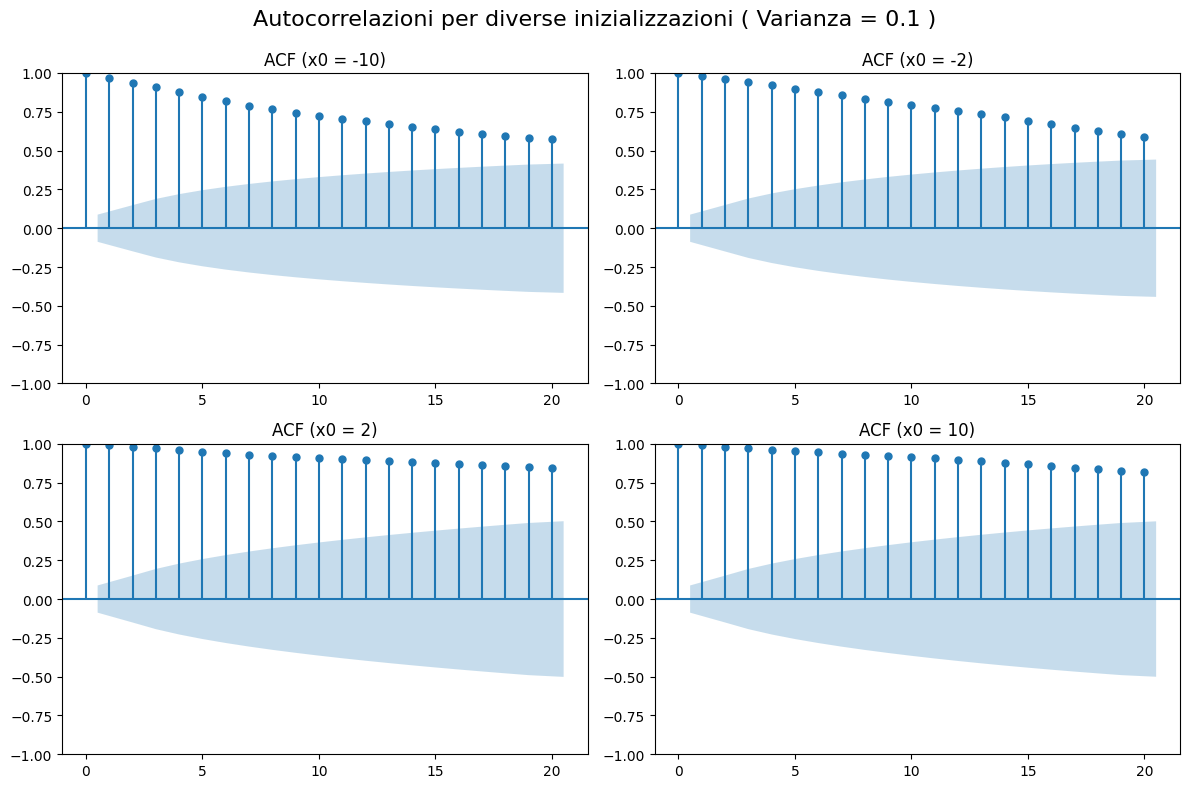

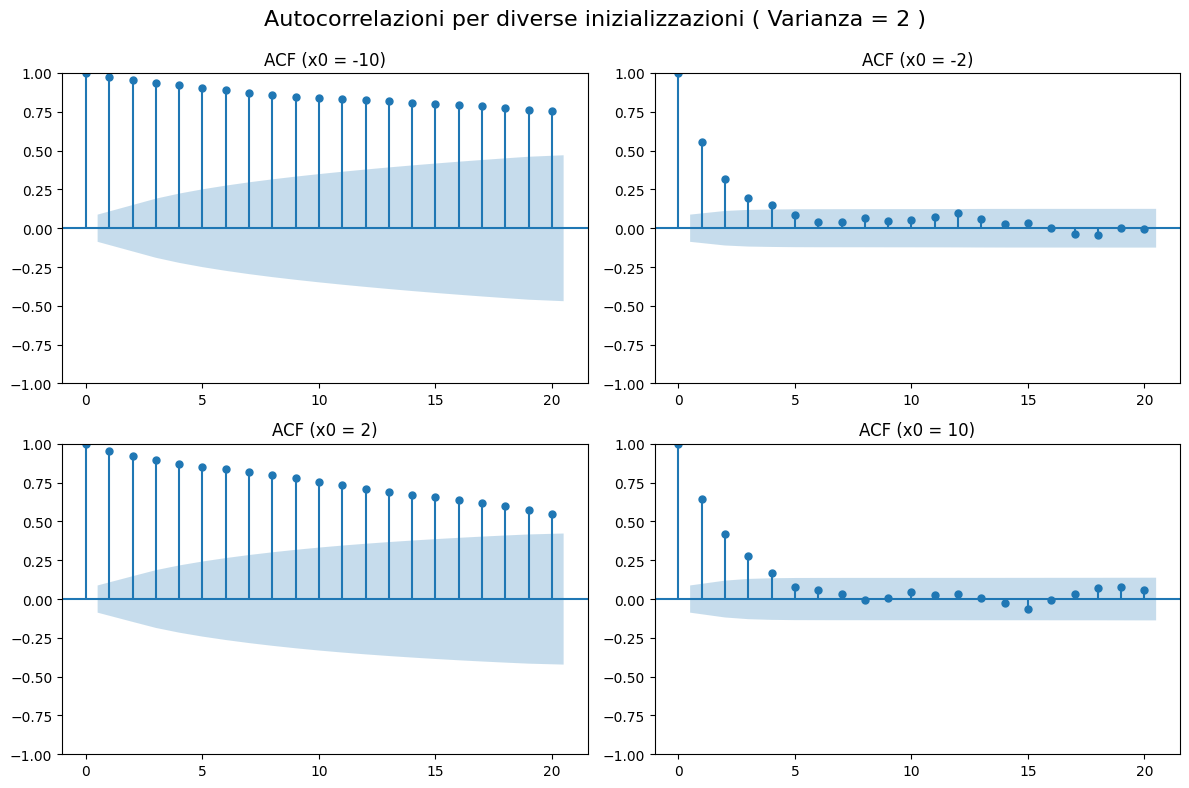

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.suptitle('Autocorrelazioni per diverse inizializzazioni ( Varianza = 0.1 )', fontsize=16)

init_vals = [-10, -2, 2, 10]
for i, ax in enumerate(axs.flat):
    tsaplots.plot_acf(chains_1_burned[i, :], lags=20, ax=ax)
    ax.set_title(f'ACF (x0 = {init_vals[i]})')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.suptitle('Autocorrelazioni per diverse inizializzazioni ( Varianza = 2 )', fontsize=16)

for i, ax in enumerate(axs.flat):
    tsaplots.plot_acf(chains_2_burned[i, :], lags=20, ax=ax)
    ax.set_title(f'ACF (x0 = {init_vals[i]})')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

'''
COMMENT:
In line with the previous plots, a higher autocorrelation is observed for the variance of 0.1, indicating that successive samples are very similar and, 
as a result, the chain is not exploring the space well. Each sample provides little new information.
When the variance is 2.0, a lower autocorrelation is observed in the case of x_0= 2 and x_0=10 ; in fact, the samples are more spread out, and the chain is therefore exploring the space more effectively.
The samples tend to be independent from one another.
'''

## P_tilde 2

In [ ]:
# Run the Metropolis-Hastings algorithm with different variances with p_tilde_2
chains_1, rejections_1 = metropolis_hastings_multi_chain(x_0_list, n_steps, sigma_1, p_tilde_2)
print(f"Rejections for Variance 0.1: {rejections_1}")
chains_2, rejections_2 = metropolis_hastings_multi_chain(x_0_list, n_steps, sigma_2, p_tilde_2)
print(f"Rejections for Variance 2.0: {rejections_2}")

# Evaluate within variance, between variance, R for both grops of chains 
within_variance_1, between_variance_1, upper_bound_1, R_1= W_B_R(chains_1)
print(f"Within variance for sigma_1: {within_variance_1} \nBetween variance for sigma_1: {between_variance_1} \nUpper bound for sigma_1: {upper_bound_1} \nR for sigma_1: {R_1}")
within_variance_2, between_variance_2, upper_bound_2, R_2= W_B_R(chains_2)
print(f"Within variance for sigma_2: {within_variance_2} \nBetween variance for sigma_2: {between_variance_2} \nUpper bound for sigma_2: {upper_bound_2} \nR for sigma_2: {R_2}")

'''
COMMENT:
The R values indicate that for both values of sigma, the chains are not converging.'''



### Catena 1 - Inizio da x[0] = -10.0 - Varianza = 0.1 ###

### Catena 2 - Inizio da x[0] = -2.0 - Varianza = 0.1 ###

### Catena 3 - Inizio da x[0] = 2.0 - Varianza = 0.1 ###

### Catena 4 - Inizio da x[0] = 10.0 - Varianza = 0.1 ###
Rejections for Variance 0.1: [76, 38, 32, 82]

### Catena 1 - Inizio da x[0] = -10.0 - Varianza = 2.0 ###

### Catena 2 - Inizio da x[0] = -2.0 - Varianza = 2.0 ###

### Catena 3 - Inizio da x[0] = 2.0 - Varianza = 2.0 ###

### Catena 4 - Inizio da x[0] = 10.0 - Varianza = 2.0 ###
Rejections for Variance 2.0: [358, 366, 349, 333]
Within variance for sigma_1: 0.3504851212501388 
Between variance for sigma_1: 4485.269663557819 
Upper bound for sigma_1: 92.01892869577998 
R for sigma_1: 16.203311955319972
Within variance for sigma_2: 2.380597390205403 
Between variance for sigma_2: 290.16171565525775 
Upper bound for sigma_2: 594.8443599194546 
R for sigma_2: 15.807336464228186


In [86]:
# List of ro_k (Varianza 0.1) 
k_1,ro_1 = compute_autocorrelations(chains_1, upper_bound_1, max_lag= 800)
# List of ro_k (Varianza 2.0)
k_2,ro_2 = compute_autocorrelations(chains_2, upper_bound_2, max_lag=800)

# effective number of samples 
n_eff_1 = num_eff(chains_1.shape[0], chains_1.shape[1], ro_1)
n_eff_2 = num_eff(chains_2.shape[0], chains_2.shape[1], ro_2)

print(f'k_1: {k_1} --->  ro list for chains_1 (sigma=0.1): {ro_1}')
print(f'k_2: {k_2} --->  ro list for chains_2 (sigma=2.0): {ro_2}')
print(f"Effettive samples for chains_1 (sigma=0.1): {n_eff_1}")
print(f"Effettive samples for chains_2 (sigma=2.0): {n_eff_2}")


k_1: 799 --->  ro list for chains_1 (sigma=0.1): [0.9999520125949101, 0.9999048201733458, 0.9998568774350675, 0.9998077674387793, 0.9997580810503901, 0.9997078382668283, 0.9996572857758346, 0.9996087055008077, 0.9995587085919249, 0.9995089960837311, 0.999459131857862, 0.9994085071443041, 0.9993571896927335, 0.9993035545675929, 0.9992472918828299, 0.9991906865895908, 0.9991350555308967, 0.9990808513709674, 0.9990258686529476, 0.998969958576734, 0.9989152433845938, 0.9988632072938652, 0.9988097109430795, 0.9987553997112645, 0.9986998382373231, 0.9986449614077795, 0.9985909828742272, 0.9985343944762582, 0.9984763750370231, 0.9984180344352009, 0.9983587597249389, 0.9982973492244783, 0.9982346509881705, 0.998170557754068, 0.9981033369026784, 0.9980355367227592, 0.9979677299676196, 0.9978998712930501, 0.9978327587388742, 0.9977631262508335, 0.9976933843907206, 0.9976237368911183, 0.9975529594584909, 0.9974818759090602, 0.99741110090904, 0.9973359751360511, 0.9972608400206722, 0.9971855558168

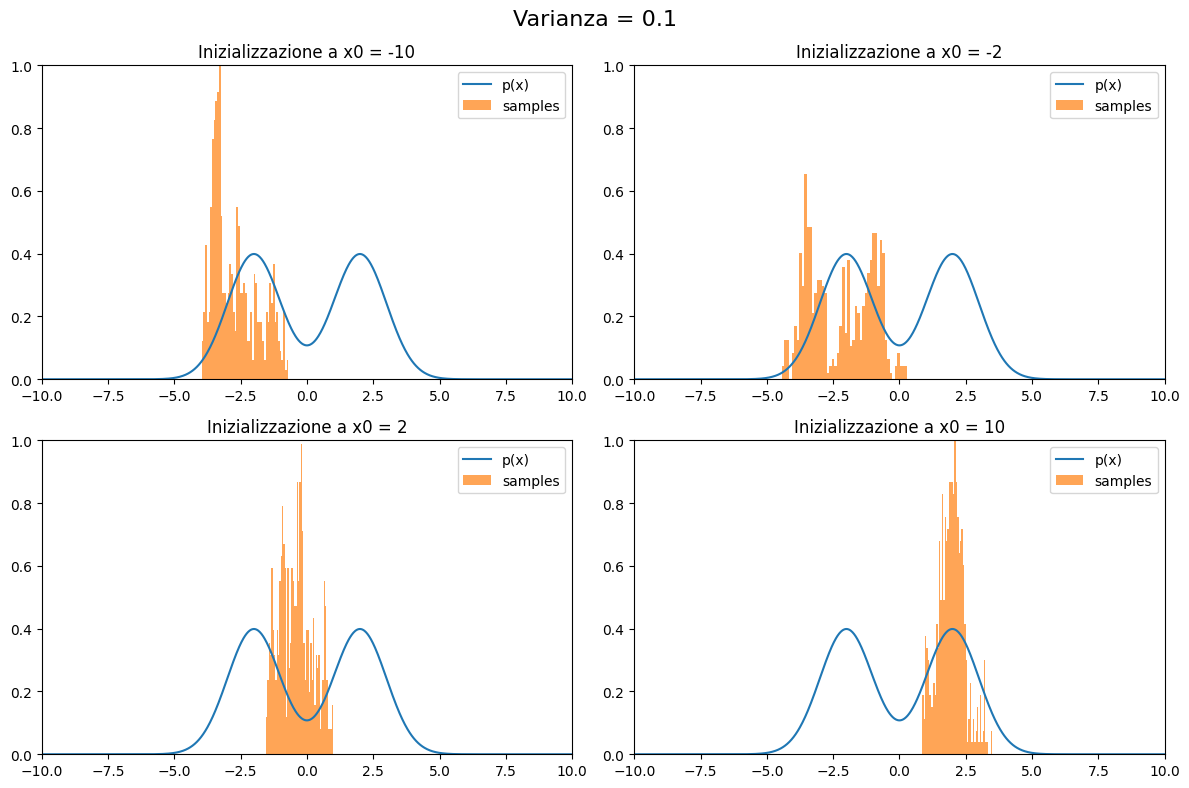

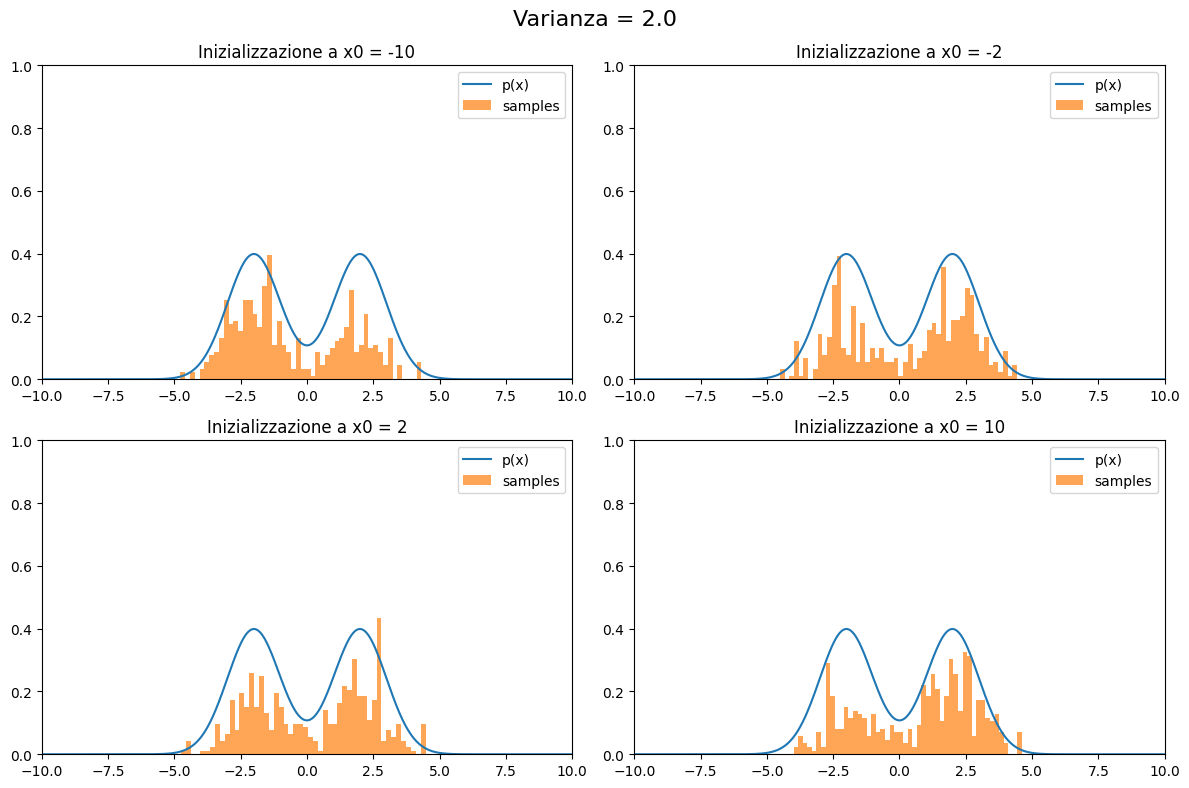

In [ ]:
burn_in = int(n_steps/2)
chains_1_burned = chains_1[:, burn_in:]
chains_2_burned = chains_2[:, burn_in:]
t = np.linspace(-10, 10, 1000)

plot_chains(chains_1_burned, t, p_tilde_2, title="Varianza = 0.1", x0_values=x_0_list)
plot_chains(chains_2_burned, t, p_tilde_2, title="Varianza = 2.0", x0_values=x_0_list)

'''
COMMENT:
It can be observed that a low variance allows exploration only in the vicinity of the starting point,
whereas a high variance enables a broader exploration of the space.
'''

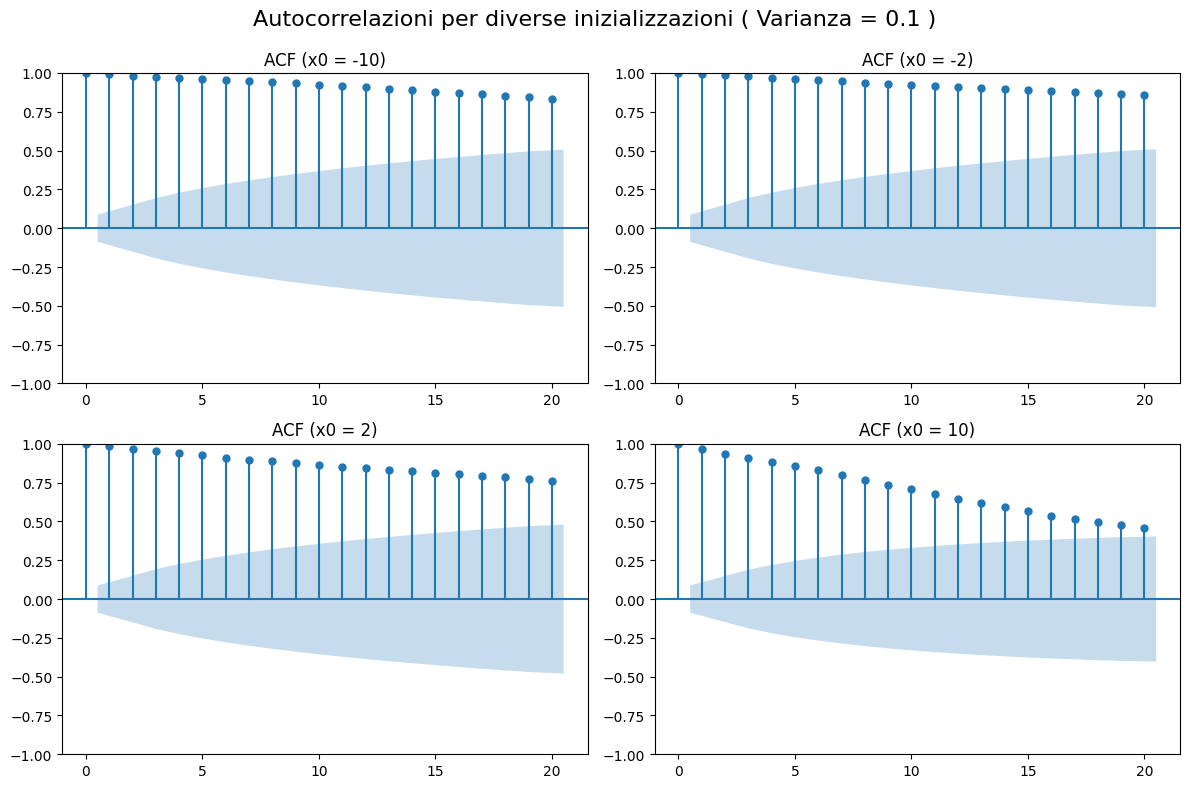

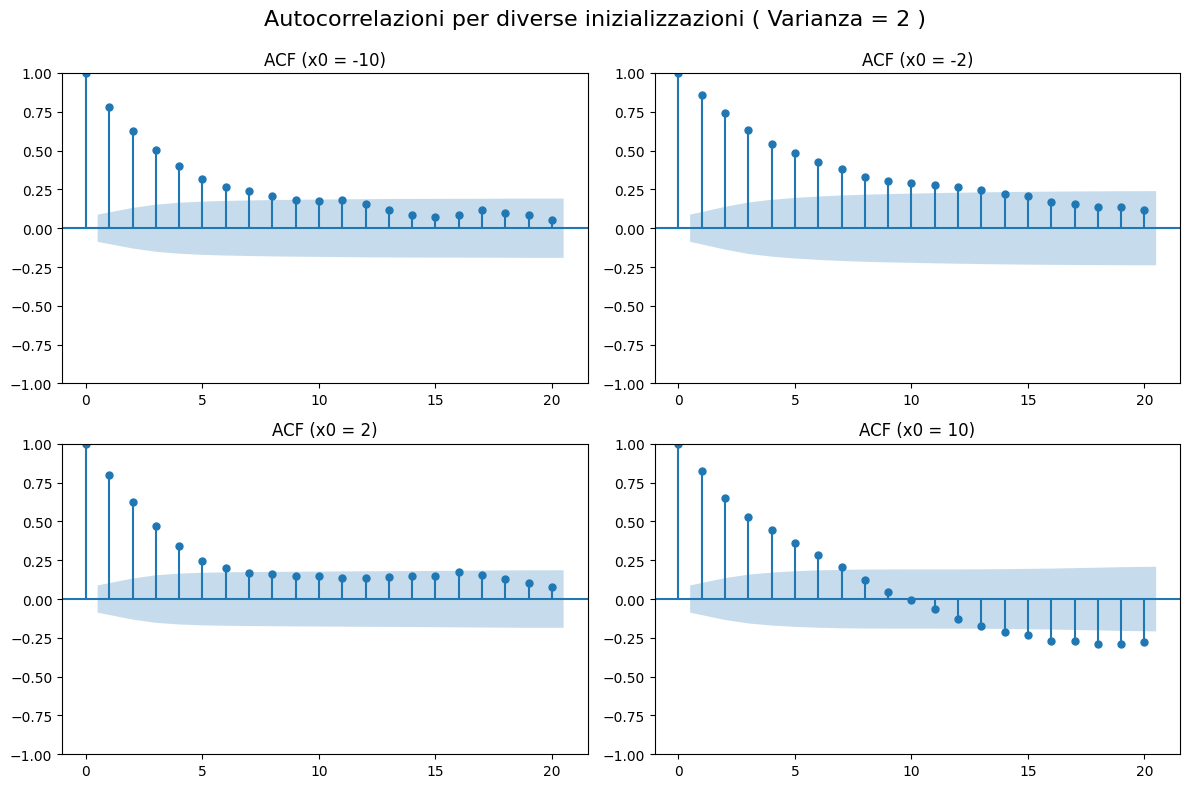

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.suptitle('Autocorrelazioni per diverse inizializzazioni ( Varianza = 0.1 )', fontsize=16)

init_vals = [-10, -2, 2, 10]
for i, ax in enumerate(axs.flat):
    tsaplots.plot_acf(chains_1_burned[i, :], lags=20, ax=ax)
    ax.set_title(f'ACF (x0 = {init_vals[i]})')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.suptitle('Autocorrelazioni per diverse inizializzazioni ( Varianza = 2 )', fontsize=16)

for i, ax in enumerate(axs.flat):
    tsaplots.plot_acf(chains_2_burned[i, :], lags=20, ax=ax)
    ax.set_title(f'ACF (x0 = {init_vals[i]})')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

'''
COMMENT:
In line with the previous plots, a higher autocorrelation is observed for the variance of 0.1, indicating that successive samples are very similar and, 
as a result, the chain is not exploring the space well. Each sample provides little new information.
When the variance is 2.0, a lower autocorrelation is observed; in fact, the samples are more spread out, and the chain is therefore exploring the space more effectively.
The samples tend to be independent from one another.
'''

### Problem 4: ADSAI football matches
Over the years, the PhD students of ADSAI have kept track of the results of their evening five-a-side football matches. Since it’s difficult to always organize teams with the same players, the teams were formed on a rotating basis, each time with different players.  
The names of our champions have been anonymized using numbers from 1 to 62.  
In the dataset located at `data/ADSAI_football.csv` in the GitHub repository, you will find the following columns:
- **Team A**: IDs of the players who played in Team A in that match;  
- **Team B**: same as above, for Team B;  
- **Goal A**: total goals scored by Team A in that match;  
- **Goal B**: same as above, for Team B.



Your goal is to model **the skill of each player** based on information about the team they belonged to and the overall result achieved by that team.



The model to implement consists in the following structure: 
- $ \theta = (\theta_1, \theta_2, \dots, \theta_{62}) \in \mathbb{R} $: players' skills.
- $M=54$: number of matches.
- For each match $ i = 1, \dots, M=54$:
  - $ A_i \subset \{1, \dots, N=62\} $: set of players IDs of team A in match $ i $.
  - $ B_i \subset \{1, \dots, N=62\} $: set of players IDs of team B in match $ i $.
  - $ y_i \in \mathbb{Z} $: observed outcome, i.e. goal difference between the two teams, defined as $ (\text{goal}_A - \text{goal}_B) $ in match $ i $.

*(in this exercise, you are asked to follow the proposal of Karlis and Ntzoufras approach, that focuses on the goal difference in place of the individual goal counts of each team!)*



The model is defined as follows:

- The "strength" of Team A, defined as the sum of the individual players' skills $\theta_j$ composing the team in match $i = 1, \dots, M=54$:  
  $$
  s_A^{(i)} = \sum_{j \in A_i} \theta_j
  $$

- The "strength" of Team B, defined similarly as the sum of the individual players' skills $\theta_j$ composing the team in match $i = 1, \dots, M=54$:  
  $$
  s_B^{(i)} = \sum_{j \in B_i} \theta_j
  $$

Specifically, the observed goal difference in match $i$ is modeled using a Skellam distribution:  
$$
y_i \sim \text{Skellam}(\lambda_A^{(i)}, \lambda_B^{(i)}), \quad \text{where} \quad \lambda_A^{(i)} = \exp(s_A^{(i)}), \quad \lambda_B^{(i)} = \exp(s_B^{(i)})
$$

The **Skellam distribution** models the difference between two independent random variables:  
$$
\text{Skellam}(\lambda_A, \lambda_B) = \text{Poisson}(\lambda_A) - \text{Poisson}(\lambda_B)
$$
It is formally defined as:  
$$
\text{Skellam}(k; \lambda_A, \lambda_B) = e^{-(\lambda_A + \lambda_B)} \left( \frac{\lambda_A}{\lambda_B} \right)^{k/2} I_{|k|}(2 \sqrt{\lambda_A \lambda_B})
$$

for each $ k \in \mathbb{Z} $, and $ I_k $ is the modified Bessel function of the first kind of order $ k $.

$$
I_k(z) = \sum_{m=0}^\infty \frac{1}{m! \, \Gamma(m + k + 1)} \left( \frac{z}{2} \right)^{2m + k}
$$

where $\Gamma$ is the Gamma function.


In [2]:
#import only relevant quantities as follows:

import pandas as pd
import ast
import torch

def preprocessing_dataset(dataset_path='../data/ADSAI_football.csv'):
    football = pd.read_csv(dataset_path)
    football['Team A'] = football['Team A'].apply(ast.literal_eval)
    football['Team B'] = football['Team B'].apply(ast.literal_eval)

    max_player_id = max(
    max(p for team in football['Team A'] for p in team),
    max(p for team in football['Team B'] for p in team)
    )

    goal_diff = torch.tensor((football['Goal A'] - football['Goal B']).values, dtype=torch.int)

    teams_A = [torch.tensor(team) for team in football['Team A']]
    teams_B = [torch.tensor(team) for team in football['Team B']]

    return teams_A, teams_B, goal_diff, max_player_id


teams_A, teams_B, goal_diff, max_player_id = preprocessing_dataset()
# print("teams_A:", teams_A)
# print("teams_B:", teams_B)
# print("goal_diff:", goal_diff)
# print("max_player_id:", max_player_id)




You are asked to: 
1. Find the MAP estimate for $ \theta = (\theta_1, \theta_2, \dots, \theta_{62})$ choosing as `log_prior` function a (log-)Standard Normal distribution and as `log_likelihood` function the (log-)Skellam. Perform optimization using Gradient Descent. Use the MAP estimate to implement a Laplace approximation of the posterior, as done during the lab (reuse the function `compute_hessian(f, w)` of Notebook 6).

**Important Hint:** The Skellam log-likelihood involves the modified Bessel function $I_k(z)$, which is non-differentiable in PyTorch if evaluated via scipy. To preserve differentiability, replace $\log I_k(z)$ with a smooth approximation, such as an asymptotic expansion, to allow gradient-based optimization.

2. **(Useful for the next point, not strictly necessary for the previous one):** Implement your `Skellam` distribution, inheriting from `torch.distributions.Distribution`;
3. Write the Pyro model corresponding to the problem depicted above assuming (again) the `theta` values being distributed initially as a Standard Normal;
4. Perform inference on $ \theta = (\theta_1, \theta_2, \dots, \theta_{62})$ values running a MCMC simulation using the `NUTS` kernel;
5. Compare the `theta` values obtained by these two options using the `performances_evaluation` function given in this notebook.


In [1]:

# 1. Find the MAP estimate for $ \theta = (\theta_1, \theta_2, \dots, \theta_{62})$ choosing as `log_prior` function a (log-)Standard Normal distribution and as `log_likelihood` function the (log-)Skellam. Perform optimization using Gradient Descent;

from torch.distributions import Normal
import torch
from tqdm.notebook import tqdm
import numpy as np
from scipy.special import iv  # Bessel function of the first kind


# asymptotic approximation of the log Bessel function of the first kind.
def log_I_alpha_asymptotic(z, alpha):
    z = z.to(dtype=torch.float32)
    alpha = alpha.to(dtype=torch.float32)

    log_Bessel = z - 0.5 * torch.log(2 * torch.pi * z)# + torch.log(1 - ((4 * alpha**2 -1) / 8 * z))
    #print(f'primo termine: {z} \n secondo termine: {-0.5 * torch.log(2 * torch.pi * z)} \n terzo termine: {(1 - ((4 * alpha**2 -1) / 8 * z))}')

    return log_Bessel 

def log_likelihood(teams_A, teams_B, goal_diff, theta):
    lambda_A_list = []
    lambda_B_list = []


    for A_i, B_i in zip(teams_A, teams_B):
        s_A = theta[A_i].sum()
        s_B = theta[B_i].sum()
        lambda_A = torch.exp(s_A)
        lambda_B = torch.exp(s_B)
    
        lambda_A_list.append(lambda_A)
        lambda_B_list.append(lambda_B)

    # Converti in tensori
    lambda_A = torch.stack(lambda_A_list)
    lambda_B = torch.stack(lambda_B_list)
    
    """
    Approssimazione differenziabile della log-probabilità Skellam.
    """
    z = 2 * torch.sqrt(lambda_A * lambda_B)
    goal_diff = goal_diff.to(lambda_A.device)
    goal_diff_abs = goal_diff.abs()

    log_bessel = log_I_alpha_asymptotic(z, goal_diff_abs)
    log_ratio_term = 0.5 * goal_diff * torch.log((lambda_A) / (lambda_B))
    # print(f"z: {z} \n lambda_A: {lambda_A} \n lambda_B: {lambda_B} \n log_bessel: {log_bessel} \n log_ratio_term: {log_ratio_term}")
    log_p = - (lambda_A + lambda_B) + log_ratio_term + log_bessel
    # print(f' log_p : {log_p}')

    return log_p.sum()

PRIOR_STD = 100

def log_prior(theta):
    
    return Normal(0, PRIOR_STD).log_prob(theta).sum()

def log_unnormalized_posterior(teams_A, teams_B, goal_diff, theta):
    # print(f"log_likelihood {log_likelihood(teams_A, teams_B, goal_diff, theta)} \n log_prior {log_prior(theta)}")
    return log_likelihood(teams_A, teams_B, goal_diff, theta) + log_prior(theta)

  
loss_function = lambda theta: -log_unnormalized_posterior(teams_A, teams_B, goal_diff, theta)

def gradient_descent_optimization(loss_function, lr: float, n_iter: int, initial_guess: torch.Tensor) -> np.ndarray:
    w = torch.tensor(initial_guess, dtype=torch.float32, requires_grad=True)
    #print(f"Initial guess 1: {w}")
    for _ in tqdm(range(n_iter)):
        # print(f"Iteration {_+1}")
        # print(f"Initial guess 2: {w}")
        loss = loss_function(w)
        #print(f"loss={ loss.item():.4g}")
        loss.backward()
        with torch.no_grad():
            #print(f"w_grad = { w.grad}")
            w -= lr * w.grad
            # print(f"Initial guess 3: {w}")
        w.grad = None
    print(f"loss={ loss.item():.4g}")
    return w.cpu().detach().numpy()

def is_positive_definite(A):
    try:
        np.linalg.cholesky(A)
        #print("Hessian is positive definite")
        return True
    except np.linalg.LinAlgError:
        #print("Hessian is not positive definite")
        return False

def compute_hessian(f, w):
    w.requires_grad = True
    grad = torch.autograd.grad(f(w), w, create_graph=True)[0]
    hessian = torch.zeros((w.numel(), w.numel()))
    for i in range(w.numel()):
        hessian[i] = torch.autograd.grad(grad[i], w, retain_graph=True)[0]

    w.requires_grad = False
    print(f' Hessian : {hessian}')

    return hessian 


In [3]:
theta_MAP = gradient_descent_optimization(loss_function = loss_function, lr=1e-4, n_iter=1100, initial_guess=np.zeros(max_player_id + 1))
hessian = compute_hessian(f = lambda theta: log_unnormalized_posterior(teams_A, teams_B, goal_diff, theta), w = torch.tensor(theta_MAP, dtype=torch.float32))
posterior_cov = torch.inverse(-hessian).numpy()

# Metodi per forzare la matrice a essere simmetrica e definita positiva
#posterior_cov = np.floor(posterior_cov * 100) / 100
#posterior_cov = 0.5 * (posterior_cov + posterior_cov.T)

print("posterior_cov:", posterior_cov)
print("theta_MAP:", theta_MAP)

  0%|          | 0/1100 [00:00<?, ?it/s]

loss=15.63
 Hessian : tensor([[-1.0000e-04,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -4.0894e-01,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  2.6325e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  5.0908e-02,
          5.1008e-02,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  5.1008e-02,
          7.9546e-02,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -1.5517e-02]])
posterior_cov: [[10000.           0.           0.       ...     0.           0.
      0.      ]
 [    0.          90.27855     67.4883   ...    21.161757  -142.02664
   -237.59549 ]
 [    0.          67.48643   -311.68036  ...    22.200298  -138.5113
   -190.43391 ]
 ...
 [    0.          21.165604    22.205402 ...  6667.947      -27.736874
   

Hessian shape: torch.Size([63, 63])


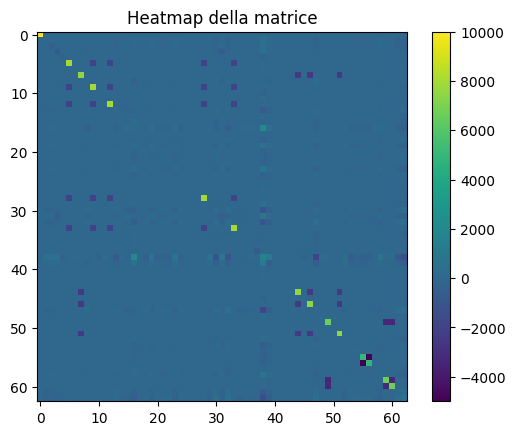

False


False

In [ ]:
# is simmetric ?
print(np.allclose(posterior_cov, posterior_cov.T))
# is positive definite ?
is_positive_definite(posterior_cov)  # True o False

In [4]:
#Visualize the marginal distribution of some thetas

import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

# Sample from the full posterior
mvn = MultivariateNormal(loc=torch.from_numpy(theta_MAP).float(), covariance_matrix=torch.from_numpy(posterior_cov).float())
posterior_samples = mvn.sample((1000,)) 

# Indices of thetas you want to visualize
selected_indices = [0, 1, 2, 20]  # Change these to the indices you're interested in

# Plot histograms
plt.figure(figsize=(10, 6))
for i, idx in enumerate(selected_indices):
    plt.subplot(2, 2, i + 1)
    plt.hist(posterior_samples[:, idx].numpy(), bins=40, density=True, alpha=0.7)
    plt.title(f"Posterior of $\\theta_{{{idx}}}$")
    plt.xlabel("Value")
    plt.ylabel("Density")
plt.tight_layout()
plt.show()


ValueError: Expected parameter covariance_matrix (Tensor of shape (63, 63)) of distribution MultivariateNormal(loc: torch.Size([63]), covariance_matrix: torch.Size([63, 63])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[10000.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000,    90.2785,    67.4883,  ...,    21.1618,  -142.0266,
          -237.5955],
        [    0.0000,    67.4864,  -311.6804,  ...,    22.2003,  -138.5113,
          -190.4339],
        ...,
        [    0.0000,    21.1656,    22.2054,  ...,  6667.9468,   -27.7369,
           -53.8811],
        [    0.0000,  -142.0273,  -138.5132,  ...,   -27.7311,   209.8329,
           348.0892],
        [   -0.0000,  -237.5966,  -190.4400,  ...,   -53.8725,   348.0888,
           731.0062]])

In [29]:
# 2. Implement your `Skellam` distribution, inheriting from `torch.distributions.Distribution`;

import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
from torch.distributions.distribution import Distribution
import scipy.special
from torch.special import i0


class Skellam(Distribution):
    arg_constraints = {
        "lambdaA": constraints.positive,
        "lambdaB": constraints.positive,
    }
    support = constraints.dependent
    has_rsample = False

    def __init__(self, lambdaA, lambdaB, validate_args=None):
        self.lambdaA, self.lambdaB = torch.broadcast_tensors(lambdaA, lambdaB)
        batch_shape = self.lambdaA.shape
        super().__init__(batch_shape, validate_args=validate_args)

    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        A = torch.poisson(self.lambdaA.expand(shape))
        B = torch.poisson(self.lambdaB.expand(shape))
        return A - B

    def log_prob(self, value):
        k = value
        lamA = self.lambdaA
        lamB = self.lambdaB

        ratio = lamA / lamB

        # Bessel function of first kind
        arg = 2 * torch.sqrt(lamA * lamB)
        goal_diff_abs = goal_diff.abs()
        iv_approx = log_I_alpha_asymptotic(arg, goal_diff_abs)
        iv_approx = torch.clamp(iv_approx, min=1e-20)  # per evitare log(0)

        log_prob = (-lamA - lamB + 0.5 * k * torch.log(ratio) + torch.log(iv_approx) )

        return log_prob

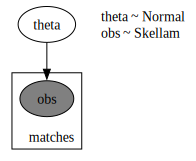

In [ ]:
# 3. Write the Pyro model corresponding to the problem depicted above assuming (again) the `theta` values being distributed initially as a Standard Normal;
def model(observations: torch.Tensor | None = None, num_matches: int | None = None):
    
    if observations is not None:
        num_matches = len(observations)
    
    # theta: abilità dei giocatori (Standard Normal prior)
    theta = pyro.sample("theta", dist.Normal(0., 1.).expand([max_player_id + 1]).to_event(1))

    with pyro.plate("matches", num_matches):
        s_A = torch.stack([theta[team].sum() for team in teams_A])
        s_B = torch.stack([theta[team].sum() for team in teams_B])

        lambda_A = torch.exp(s_A)
        lambda_B = torch.exp(s_B)

        goal_diff = pyro.sample("obs", Skellam(lambda_A, lambda_B), obs=observations)
    
    return {'obs': goal_diff}


# 2: plot the corresponding graphical model
pyro.render_model(model, model_kwargs= {'observations': goal_diff}, render_distributions=True)


In [25]:
# samples_1 = pd.DataFrame(model(num_matches=10))    
# samples_1
samples_2 = pd.DataFrame(model(observations=goal_diff))    
samples_2

,obs
0,-5
1,-2
2,-1
3,4
4,1
5,8
6,6
7,-1
8,-2
9,-5


In [ ]:
 
# 4. Perform inference on $ \theta = (\theta_1, \theta_2, \dots, \theta_{62})$ values running a MCMC simulation using the `NUTS` kernel;

from pyro.infer import MCMC, NUTS
kernel = NUTS(model) 
mcmc = MCMC(kernel, num_samples=1000, warmup_steps=500)
mcmc.run(observations = goal_diff)
mcmc.summary()

theta_MCMC = ...

'''
COMMENT:
The obtained values are not very reliable because the effective sample size for each chain is very low, and the R-hat values
often exceed 1 by a significant margin, indicating that the chains are not converging.
'''


Sample: 100%|██████████| 1500/1500 [02:08, 11.68it/s, step size=5.27e-02, acc. prob=0.764]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.27      0.80      0.11     -0.93      1.55     12.30      1.24
  theta[1]      4.29      0.24      4.29      3.94      4.65     14.25      1.32
  theta[2]     -4.26      0.45     -4.19     -5.01     -3.53      4.93      1.32
  theta[3]     -0.63      0.14     -0.62     -0.87     -0.39      7.28      1.72
  theta[4]      0.17      0.36      0.08     -0.41      0.73      4.08      1.76
  theta[5]      0.29      0.79      0.30     -1.11      1.42      6.22      1.67
  theta[6]    -12.75      0.27    -12.74    -13.30    -12.39      7.74      1.12
  theta[7]      0.38      0.77      0.25     -0.87      1.48      7.22      1.08
  theta[8]      1.32      0.89      1.53     -0.45      2.50      5.56      1.07
  theta[9]     -0.50      0.16     -0.53     -0.70     -0.17      5.57      1.41
 theta[10]     14.84      0.34     14.76     14.39     15.40      4.60      1.36
 theta[11]      2.50      0

In [ ]:

# 5. Compare the `theta_*` values obtained by these two options using the `performances_evaluation` function given in this notebook.

import numpy as np
import torch

def predict_goal_diff_skellam(teamA_ids, teamB_ids, theta, n_sim=10_000, posterior_cov=None):
    """
    Predicts the goal difference (Skellam distribution) between two teams using theta.

    Args:
        teamA_ids (list): Indices of the players in team A.
        teamB_ids (list): Indices of the players in team B.
        theta (torch.Tensor): Tensor containing the skill levels of the players.
        n_sim (int): Number of simulations to run.

    Returns:
        float: Mean predicted goal difference (A - B).
    """

    # Calculate the total strength for each team (sum of player skill levels)
    sA = theta[teamA_ids].sum()
    sB = theta[teamB_ids].sum()

    # Lambda parameters for Poisson distribution (expected goals)
    lam_A = torch.exp(sA).item()  # Team A's expected goal rate
    lam_B = torch.exp(sB).item()  # Team B's expected goal rate

    # Simulate goals for each team using Poisson distribution
    goals_A = np.random.poisson(lam_A, size=n_sim)
    goals_B = np.random.poisson(lam_B, size=n_sim)

    # Calculate the difference in goals (A - B)
    diff = goals_A - goals_B

    # Return the mean predicted difference
    return diff.mean()


def predict_goal_diff_laplace(teamA_ids, teamB_ids, theta_map, cov_matrix, n_sim=1000):
    # Combine all relevant indices
    all_ids = torch.tensor(sorted(set(teamA_ids) | set(teamB_ids)))

    # Extract subvector of means (mu_A and mu_B)
    theta_sub = theta_map[all_ids].float()

    # Extract submatrix of covariances
    cov_sub = cov_matrix[np.ix_(all_ids, all_ids)]  # numpy version
    cov_sub = torch.from_numpy(cov_sub).float()

    # Create multivariate normal from posterior
    mvn = MultivariateNormal(loc=theta_sub, covariance_matrix=cov_sub)

    # Sample from posterior
    theta_samples = mvn.sample((n_sim,))  # shape: (n_sim, len(all_ids))

    # Compute strength for each team in each sample
    teamA_len = len(teamA_ids)
    sA = theta_samples[:, :teamA_len].sum(dim=1)
    sB = theta_samples[:, teamA_len:].sum(dim=1)

    # Expected goals via Poisson lambdas
    lam_A = torch.exp(sA)
    lam_B = torch.exp(sB)

    # Sample goals
    goals_A = torch.poisson(lam_A)
    goals_B = torch.poisson(lam_B)

    # Goal differences
    diff = goals_A - goals_B
    return diff.mean()


def evaluate_performance(theta_MAP, theta_MCMC, posterior_cov, teams_A, teams_B, goal_diff, n_sim=10_000):
    """
    Evaluates the performance of different sets of theta values by comparing the Mean Bias Error (MBE)
    and Mean Absolute Error (MAE) between predicted and actual goal differences.

    Args:
        theta_values (list of torch.Tensor): List of different theta values to evaluate.
        teams_A (list of lists): List of player IDs for team A in each match.
        teams_B (list of lists): List of player IDs for team B in each match.
        goal_diff (list): List of actual goal differences (A - B).
        n_sim (int): Number of simulations to run for each set of theta values.

    Returns:
        dict: Dictionary with MBE and MAE for each set of theta values.
    """
    results = {}

    # Loop through each set of theta values
 
    predicted_diffs_MAP = []  # List to store predicted goal differences
    predicted_diffs_MCMC = []
    actual_diffs = goal_diff  # Actual goal differences

    # Simulate the match results for each game
    for i in range(len(goal_diff)):
        teamA_ids = teams_A[i]
        teamB_ids = teams_B[i]

        # Predict the goal difference 
        # Use the Laplace approximation if posterior_cov is provided
        
        predicted_MAP = predict_goal_diff_laplace(teamA_ids, teamB_ids, theta_MAP, posterior_cov, n_sim)
        predicted_MCMC = predict_goal_diff_skellam(teamA_ids, teamB_ids, theta_MCMC, n_sim)
        
        predicted_diffs_MAP.append(predicted_MAP)
        predicted_diffs_MCMC.append(predicted_MCMC)

    # Convert lists to numpy arrays for easier calculations
    predicted_diffs_MAP = np.array(predicted_diffs_MAP)
    predicted_diffs_MCMC = np.array(predicted_diffs_MCMC)
    actual_diffs = np.array(actual_diffs)

    # Compute MAE and MBE
    mae_MAP = np.mean(np.abs(predicted_diffs_MAP - actual_diffs))  # Mean Absolute Error
    mbe_MAP = (predicted_diffs_MAP - actual_diffs).mean()  # Mean Bias Error
    mae_MCMC = np.mean(np.abs(predicted_diffs_MCMC - actual_diffs))  # Mean Absolute Error
    mbe_MCMC = (predicted_diffs_MCMC - actual_diffs).mean()  # Mean Bias Error

    # Store results for the current theta set
    results = {'MAE_MAP': mae_MAP, 'MBE_MAP': mbe_MAP,
              'MAE_MCMC': mae_MCMC, 'MBE_MCMC': mbe_MCMC}

    return results


# Evaluate the performance of different theta values on the same dataset used to fix those values
performance_results = evaluate_performance(theta_MCMC, theta_MAP, posterior_cov, teams_A, teams_B, goal_diff)

# Print the results
print("Performance Results:")
print(f"MAP - MAE: {performance_results['MAE_MAP']}, MBE: {performance_results['MBE_MAP']}")
print(f"MCMC - MAE: {performance_results['MAE_MCMC']}, MBE: {performance_results['MBE_MCMC']}")